# Titanic

In [126]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict;
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict;
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix;
from sklearn.metrics import precision_recall_curve;
from sklearn.metrics import roc_curve;
from sklearn.metrics import roc_auc_score;
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix;
import os
np.random.seed(42)
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Primera observacion de los datos

In [73]:
titanic_origen = pd.read_csv("./datasets/titanic.xls")
titanic_origen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


In [74]:
titanic_origen.duplicated().sum()

0

- Hay 5 columnas categoricas.
- No hay valores duplicados.
- Hay columnas como PassengerId, Name, Ticket que no tienen un valor importante a la hora de clasificar. Las eliminaremos.
- Hay varios valores nulos en las columnas Age y Fare. En Cabin tambien, sin embargo la eliminaremos porque apenas tiene valores.

In [75]:
titanic_origen.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#### Corrigiendo valores NaN

- Vamos a crear una copia para no alterar el dataset original

In [110]:
titanic = titanic_origen.copy()

In [111]:
for col in ["Age", "Fare"]:
    media = titanic[col].median()
    titanic[col].fillna(media, inplace=True)

In [112]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          418 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         418 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


#### Eliminando columnas innecesarias

In [113]:
titanic.drop(columns=["PassengerId", "Name", "Cabin", "Ticket"], axis=1, inplace=True)

In [114]:
titanic.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

#### Estudiando los datos con graficas

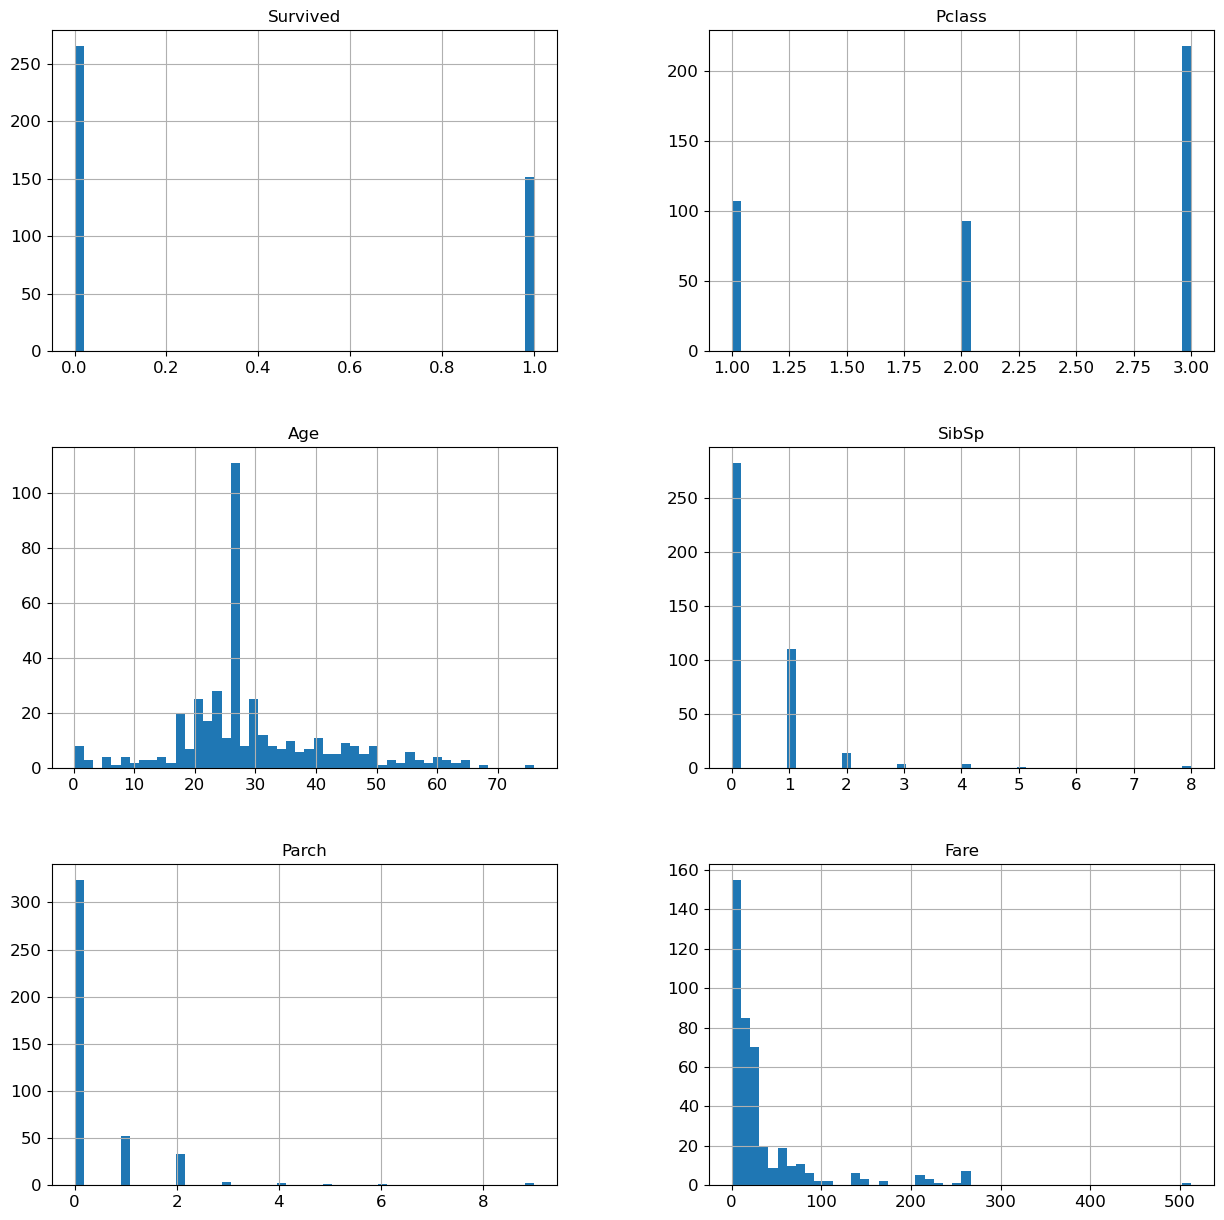

In [81]:
titanic.hist(bins=50, figsize=(15,15));

In [84]:
def categorizar_edad(edad):
    if edad < 18:
        return 'joven'
    else:
        return 'adulto'

In [85]:
copy = titanic.copy()
copy["Edad"] = copy['Age'].apply(categorizar_edad)


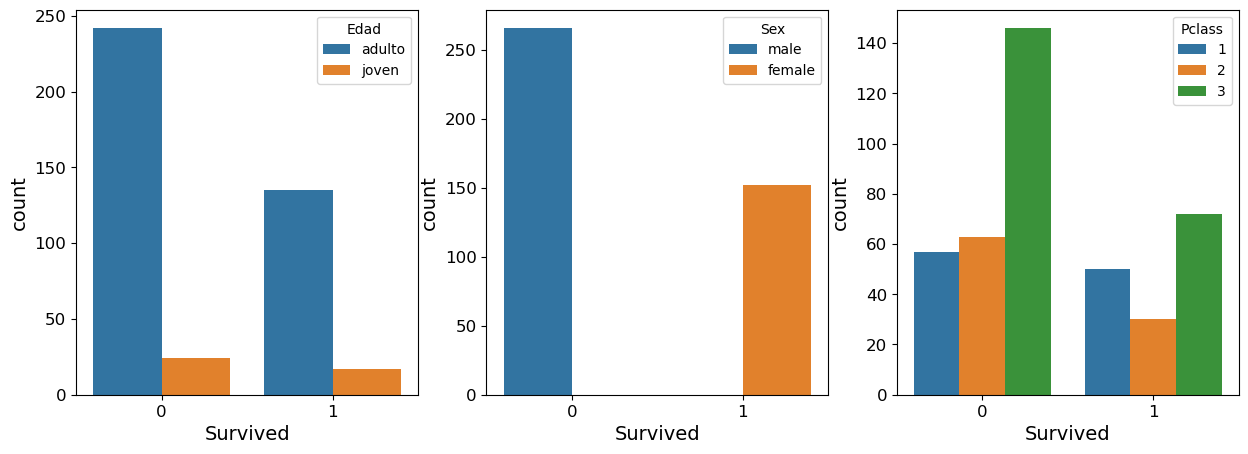

In [86]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
sns.countplot(x='Survived', hue = 'Edad',data=copy, ax=axs[0])
sns.countplot(x='Survived', hue = 'Sex',data=titanic_origen, ax=axs[1])
sns.countplot(x='Survived', hue = 'Pclass',data=titanic, ax=axs[2])
plt.show()

#### Descategorizando columnas
- Vamos a utilizar la clase OneHotencoder para transformar cada valor de cada columna en una nueva columna con valores binarios (0 y 1).

In [115]:
titanic_cat = titanic[["Embarked", "Sex"]]
titanic_cat

,Embarked,Sex
0,Q,male
1,S,female
2,Q,male
3,S,male
4,S,female
...,...,...
413,S,male
414,C,female
415,S,male
416,S,male


In [116]:
for col in titanic_cat.columns:
    oneHot_encoder = OneHotEncoder(sparse=False)
    cat_1hot_encoded = oneHot_encoder.fit_transform(titanic_cat[[col]])
    titanic.reset_index(drop=False, inplace=True)
    titanic=titanic.join(pd.DataFrame(cat_1hot_encoded, columns=[cat for cat in oneHot_encoder.categories_[0]]))
    titanic=titanic.drop([col,'index'], axis=1);

In [117]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  418 non-null    int64  
 1   Pclass    418 non-null    int64  
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   C         418 non-null    float64
 7   Q         418 non-null    float64
 8   S         418 non-null    float64
 9   female    418 non-null    float64
 10  male      418 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 36.0 KB


#### Analizamos correlaciones
- Las correlaciones nos mostraran que variable esta mas relacionada con la supervivencia.

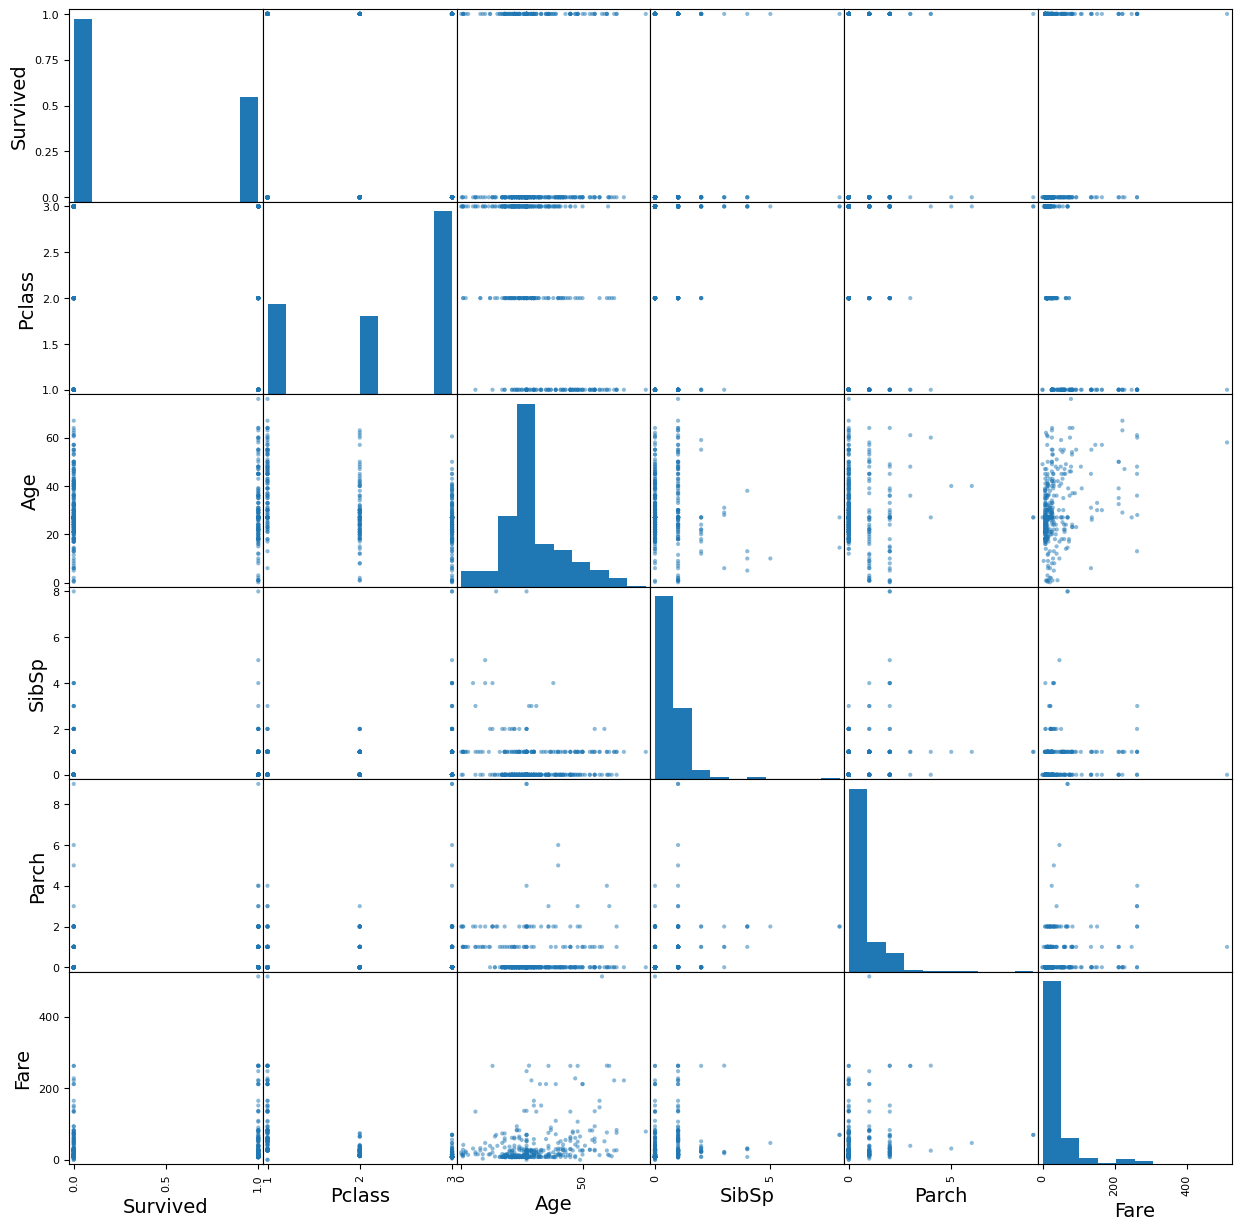

In [90]:
scatter_matrix(titanic, figsize=(15, 15));

In [25]:
corr_matrix = titanic.corr();

In [87]:
corr_matrix['Survived'].sort_values(ascending=False)

Survived    1.000000
female      1.000000
Fare        0.192036
Parch       0.159120
Q           0.115574
SibSp       0.099943
C           0.033684
Age         0.008035
S          -0.105883
Pclass     -0.108615
male       -1.000000
Name: Survived, dtype: float64

### Preparando los conjuntos de entrenamiento y validacion

- Dividimos los los datos en datos de entreno (80%) y validacion (20%);

In [118]:
X_train, X_test = train_test_split(titanic, test_size=0.20, random_state=42)
len(X_train), len(X_test)

(334, 84)

- Creamos una variable del conjunto de resultados de entreno y eliminamos estos del conjunto de entreno.

In [119]:
y_train = X_train["Survived"].copy()
X_train = X_train.copy().drop("Survived", axis=1)

- Creamos una variable del conjunto de resultados de validacion y eliminamos estos del conjunto de validacion.

In [120]:
y_test = X_test["Survived"].copy()
X_test = X_test.copy().drop("Survived", axis=1)

- Generamos una muestra de tres instancias aleatorias para ver comodamente las predicciones.

In [121]:
some_data = X_test.sample(3)

In [124]:
len(y_train), len(y_test)

(334, 84)

### Entrenando modelos

#### *SGDClassifier*: El SGD es un modelo de clasificacion binaria basado en el descenso del gradiente estocastico.

In [130]:
sgd_clf = SGDClassifier(penalty='l1', alpha=0.1, random_state=42)
sgd_clf.fit(X_train, y_train)
y_pred_sgd = sgd_clf.predict(X_test)
y_pred_sgd

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1], dtype=int64)

In [131]:
sgd_score = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')
sgd_score.mean()

0.9553571428571429

In [133]:
y_pred_sgd = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
confusion_matrix(y_train, y_pred_sgd)

array([[216,   0],
       [ 15, 103]], dtype=int64)

In [134]:
precision = precision_score(y_train, y_pred_sgd)
recall = recall_score(y_train, y_pred_sgd)
f1 = f1_score(y_train, y_pred_sgd)

precision, recall, f1

(1.0, 0.8728813559322034, 0.9321266968325792)

In [137]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=3, method="decision_function");

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores);

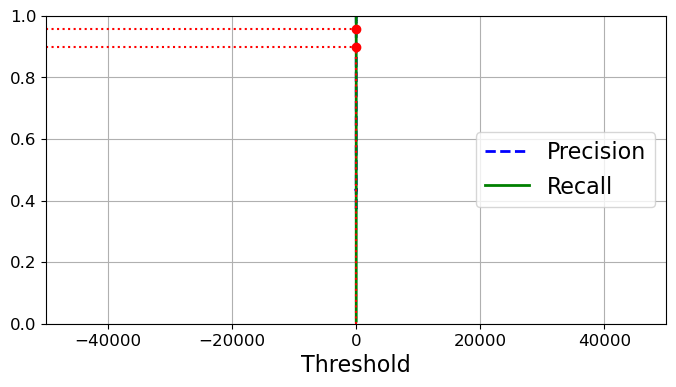

In [138]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2);
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2);
    plt.legend(loc="center right", fontsize=16);
    plt.xlabel("Threshold", fontsize=16);
    plt.grid(True);
    plt.axis([-50000, 50000, 0, 1]);

recall_90_precision = recalls[np.argmax(precisions >= 0.90)];
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)];

plt.figure(figsize=(8, 4));
plot_precision_recall_vs_threshold(precisions, recalls, thresholds);
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:");
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:");
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:");
plt.plot([threshold_90_precision], [0.9], "ro");
plt.plot([threshold_90_precision], [recall_90_precision], "ro");
plt.show();